<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам


In [3]:
RUN_FROM_0 = False #учим (True) языковые модели или нет

In [4]:
#%%javascript
#IPython.OutputArea.prototype._should_scroll = function(lines) {
#    return false;
#}

https://webdevblog.ru/gensim-rukovodstvo-dlya-nachinajushhih/  
https://markroxor.github.io/gensim/static/notebooks/lda_training_tips.html

In [5]:
!pip install pymystem3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from scipy import spatial
import sklearn
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import os
import math

from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor


import ast
import json

#from sklearn.preprocessing import StandardScaler

import gensim
from gensim import corpora
from pprint import pprint
from gensim.models import LdaModel, LdaMulticore, Phrases

import gensim.downloader as api
from gensim.utils import simple_preprocess, lemmatize
import re

# You need to install two libraries:
# * nltk - to get russian stopwords
# * pymystem3 - for lemmatization

# download stopwords corpus, you need to run it once
import nltk
nltk.download("stopwords")


from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

from itertools import chain
from collections import defaultdict
from operator import itemgetter

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
import warnings; warnings.simplefilter('ignore')

In [8]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [9]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [10]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Setup

In [11]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/links04/car_links_04.txt
/kaggle/input/parseautoru/SF-DST-10 Car Price prediction Kuzmenko -parse auto_ru.ipynb
/kaggle/input/langdata/DOC2VEC_model.model
/kaggle/input/langdata/lda_model.model.state
/kaggle/input/langdata/lda_model.model.id2word
/kaggle/input/langdata/lda_model.model.expElogbeta.npy
/kaggle/input/langdata/lda_model.model
/kaggle/input/sf-dst-car-price/sample_submission.csv
/kaggle/input/sf-dst-car-price/test.csv
/kaggle/input/04-09-2020/car_links_cars_04.txt
/kaggle/input/dillers/dillers_txt.csv


In [12]:
VERSION    = 37
DIR_TRAIN  = '../input/04-09-2020/' # подключил к ноутбуку свой внешний датасет
DIR_TEST   = '../input/sf-dst-car-price/'
VAL_SIZE   = 0.1 #0.33   # 33%
N_FOLDS    = 5

CURR_YEAR = 2020
DILLER_THRESHOLD = 0.48 # Отсечка по cosine расстоянию между dtscription и "диллерскими текстами"
PRICE_IN_TIME = 0.89 # За время соревнования (7- мес) цены на подержанные авто выросли
ROUND_C = int(5000)
# CATBOOST
ITERATIONS = 5000#4000
LR         =0.05#
OD_PVAL = 0.002 #0.002 
L2_REG = 4.5 # Борьба с переобучением

# Data

In [13]:
!ls ../input/

04-09-2020  dillers  langdata  links04	parseautoru  sf-dst-car-price


In [14]:
train_in = pd.read_json(DIR_TRAIN+'car_links_cars_04.txt') # мой подготовленный датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [15]:
def param_data(data):
    
    '''
    Посмотрим на данные
    ''' 
    param = pd.DataFrame({
                'dtypes': data.dtypes.values,
                'nunique': data.nunique().values,
                'isna': data.isna().sum().values,
                'loc[0]': data.loc[0].values,
                }, 
                index = data.loc[4].index)
    return param

---  
# Посмотрим на данные

In [16]:
param_data(train_in)

,dtypes,nunique,isna,loc[0]
bodyType,object,12,2,седан
brand,object,1,2,BMW
color,object,16,2,чёрный
fuelType,object,4,2,бензин
modelDate,float64,41,2,2005
name,object,543,2,318i 2.0 MT (143 л.с.)
numberOfDoors,float64,4,2,4
productionDate,float64,55,2,2007
vehicleConfiguration,object,419,2,SEDAN MECHANICAL 2.0
vehicleTransmission,object,3,2,механическая


* ****bodyType****  
Categorical  
HIGH CORRELATION - numberOfDoors  

* ****color**** 
Categorical  

* ****fuelType****  
Categorical  

* ****modelDate****  
Real number  
HIGH CORRELATION - productionDate  
интересны АМ с 1980

* ****name****  
Categorical

* ****numberOfDoors****  
Categorical  
HIGH CORRELATION - bodyType

* ****productionDate****  
Real number  
HIGH CORRELATION - modelDate    
интересны АМ с 1980  

* ****vehicleConfiguration****  
Categorical  
HIGH CARDINALITY  
пропущено 3395   
Distinct count	414  
Попробуем восстановить из других данных или удалим

* ****vehicleTransmission****  
Categorical  

* ****engineDisplacement****    
Categorical  
Приведем к числу  

* ****enginePower****  
Categorical  
HIGH CARDINALITY  
Приведем к числу  

* ****mileage****  
Real number   
Есть выбросы - ограничим побег 300000км - далее уже нужно смотреть на каждый АМ на диагностике, всё крайне индивидуально  

* ****Комплектация****  
Categorical  
HIGH CARDINALITY  
Distinct count	5462  
Здесь json массив с пакетами опций и их перечислением (не всегда есть пакеты, а есть опции) - стоит анализировать  

* ****Привод****
Categorical  

* ****Руль****  
Categorical  
Unique(%) < 0.1% - не имеет смысла использовать  

* ****Состояние****  
Categorical  
CONSTANT    
Удаляем  

* ****Владельцы****  
Categorical  
Кажется важным фактором  

* ****ПТС****  
Categorical  
Оригинал 7939  
Дубликат 1870  

* ****Таможня****  
Categorical  
CONSTANT  
Удаляем  

* ****Владение****  
Categorical  
HIGH CARDINALITY  
-NaN-	6427  
Отбрасываем  
Не смогли собрать в 65% случаев - жаль, признак представляется крайне важным  

* ****url****
UNIQUE  
Отбрасываем  

* ****price****  
Real number  
Очень смещенное влево распределение. Есть значения порядка 12млн руб - такое возможно, проверил. В среднем около 1млн  

* ****description****  
Categorical  
HIGH CARDINALITY  
Distinct count	9509  
Здесь неструктурированный текст - попробуем проанализировать с использованием ntlk  

In [17]:
train_in.dropna(axis=0, how='all', inplace=True)
train_in = train_in[(~ train_in.price.isnull()) & (train_in['productionDate'] >=1980)] #антиквариат будет только мешать
train_in.fillna('-NaN-', inplace=True)
train_in.vehicleConfiguration[train_in.vehicleConfiguration.str.strip() == '']= '-NaN-'

train_in = train_in.reset_index()
train_in.drop(['index'], inplace=True, axis=1)


In [18]:
train = train_in.copy()# Все города миллионники
#train = train_in.head(6700)# Только Москва

### Построим статистику по датасету - *АВТОМАТИЧЕСКИ* используя Pandas Profiling - Kaggle поддерживает данную библиотеку 

In [19]:
#design_report = ProfileReport(train); #закомментировано для git

In [20]:
#design_report.to_notebook_iframe(); #закомментировано для git

## Обработка русского текста 
--------------------

In [21]:
def cluster_it(data, n_clusters, prefix='Grp_ID'):
    '''
    Кластер K-nn
    '''
    k_means = KMeans(n_clusters=n_clusters,#3 
                     n_init=10,
                     max_iter=300,
                     init='k-means++',
                     random_state=RANDOM_SEED,
                     n_jobs=-1
                    )
    #XX = StandardScaler().fit_transform(ser) 
    k_means.fit(data)#XX)
    y_pred1 = k_means.labels_.astype(np.int).T
    ret = pd.Series(y_pred1)
    ret.name=prefix#'Grp_ID'
    return ret

In [22]:
 def draw_clusters_optimum_N(data): 
    '''
    Определим оптимальное к-во кластеров для группировки тем в описании авто
    '''
    if RUN_FROM_0 == False: return # Работает только на этапе разработки
    N=30
    distortions = []
    for i in range(1,N):
        k_means = KMeans(n_clusters=i,#3 
                         init='k-means++', # 'k-means++', 'random', numpy.array
                         n_init=10,
                         max_iter=300,
                         random_state=RANDOM_SEED
                        )
        #XX = StandardScaler().fit_transform(data)#pd.concat([pr_train, pr_test], axis=0)) #pr_train)
        k_means.fit(data)#XX)
        distortions.append(k_means.inertia_)
    plt.plot(range(1,N), distortions, marker='o')
    plt.xlabel('Число кластеров')
    plt.ylabel('Искажение')
    plt.show()

In [23]:
def draw_clusters(data, n_clust):
    '''
    Отрисовка кластеров, максимум 10 (если больше-добавить цвета)
    '''
    if RUN_FROM_0 == False: return # Работает только на этапе разработки
    kmeans_model = KMeans(n_clusters=n_clust, n_init=10,
                     max_iter=300,
                     init='k-means++',
                     random_state=RANDOM_SEED,
                     n_jobs=-1)
    
    X = kmeans_model.fit(data)
    labels=kmeans_model.labels_.tolist()
    l = kmeans_model.fit_predict(data)
    pca = PCA(n_components=2).fit(data)
    datapoint = pca.transform(data)
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure
    label1 = ['#FFFF00', '#008000', '#0000FF', '#800080', '#800000', '#8d9091', '#009fe3', '#ff5a00', '#bc34ba', '#00a353'  ]
    color = [label1[i] for i in labels]
    plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
    centroids = kmeans_model.cluster_centers_
    centroidpoint = pca.transform(centroids)
    plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
    plt.show()

In [24]:
class TextTpoics(object):
    '''
    Текст в N-топиков
    '''   
    def __init__(self, random_state, n_topics, additional_stopwords=[]):
        self.random_state = random_state
        self.mystem = Mystem() 
        self.russian_stopwords = stopwords.words("russian")
        self.russian_stopwords.extend(additional_stopwords)
        self.lda_model = None
        self.n_topics = n_topics
    # In this kernel I'll show you how easy it is to preprocess the text in Russian.
    #Create lemmatizer and stopwords list


    def deEmojify(self, text):
        '''
        Удаляем эмодзи
        '''

        return text  #временно не чистим эмодзи
    
    
        regrex_pattern = re.compile(pattern = "["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002500-\U00002BEF"  # chinese char
                                   u"\U00002702-\U000027B0"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   u"\U0001f926-\U0001f937"
                                   u"\U00010000-\U0010ffff"
                                   u"\u2640-\u2642"
                                   u"\u2600-\u2B55"
                                   u"\u200d"
                                   u"\u23cf"
                                   u"\u23e9"
                                   u"\u231a"
                                   u"\ufe0f"  # dingbats
                                   u"\u3030"
                               "]+", flags = re.UNICODE)
        return regrex_pattern.sub(r'',text)

    #Preprocess function
    def preprocess_text(self, text):
        '''
        Лемматизация строки текста и удаление эмодзи 
        '''
        tokens = self.mystem.lemmatize(text.lower())
        tokens = [token for token in tokens if token not in self.russian_stopwords\
                  and token != " " \
                  and token.strip() not in punctuation]
        

                    
        text = " ".join(tokens)

        return text
    
    def bigrams(self, docs):
        return docs # биграммы не заработали - на будущее
        # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
        bigram = Phrases(docs, min_count=20)
        for idx in range(len(docs)):
            for token in bigram[docs[idx]]:
                if '_' in token:
                    # Token is a bigram, add to document.
                    docs[idx].append(token)
        print(docs)
        return docs

    def clean_and_lemmatize_text_series(self, series):
        '''
        Получение лемматизаированного объема текста из Series и удаление эмодзи 
        '''
        lemmatized_textd = series.apply(self.preprocess_text) #train_in['description'].apply(preprocess_text)
        lem_str_list = [[self.deEmojify(text) for text in doc.split()] for doc in lemmatized_textd]
        #print(lem_str_list)
        return self.bigrams(lem_str_list)

    def clean_and_lemmatize_text_text(self, txt):
        '''
        Получение лемматизаированного объема текста из Str и удаление эмодзи 
        '''
        lemmatized_textd = self.preprocess_text(txt) #train_in['description'].apply(preprocess_text)
        lem_str_list = [[self.deEmojify(text) for text in doc.split()] for doc in [lemmatized_textd]]
        return self.bigrams(lem_str_list)

    def create_dictionary_and_corpus_4_LDA(self, lem_str_list):
        '''
        Создание Dictionary и Corpus для LDA model из Series: 
        '''
        dct = corpora.Dictionary(lem_str_list)
        # Filter out words that occur less than 20 documents, or more than 50% of the documents.
        #dct.filter_extremes(no_below=20, no_above=0.5)
        corpus = [dct.doc2bow(line) for line in lem_str_list]
        return dct, corpus

    def get_corpus_and_dict_from_txt(self, txt):
        '''
        Создание Dictionary и Corpus для LDA model из Txt: 
        '''
        dct, corpus = self.create_dictionary_and_corpus_4_LDA(self.clean_and_lemmatize_text_text(txt))
        return dct, corpus 
    

    def predict_tpoics_by_text(self, txt):
        '''
        Предсказание топиков по необработанной строке текста
        '''
        dct, corpus = self.get_corpus_and_dict_from_txt(txt)

        return self.lda_model[corpus][0][0]
    
    def predict_topics_by_series(self, ser):
        '''
        Получение "текстовых групп"
        '''
        
        tqdm.pandas()
        dd = ser.progress_apply(self.predict_tpoics_by_text)
        res_arr=[] 
        for d in tqdm(dd, total=dd.shape[0]):
            arr = [0] * self.n_topics
            for i in range(0,len(d)):
                arr[d[i][0]] = d[i][1]
            res_arr.append(arr)
            
        res_arr = np.array(res_arr)
        
        return pd.DataFrame(data=res_arr, columns=['desr_topic_'+ str(i) for i in range(0, self.n_topics)])

    def train_tpoics_by_series_of_text(self, series, workers=3, path_to_save_model=''):
        '''
        Обучение модели по Series Txt
        с возможностью сохранения обученной модели
        '''
        
        lem_str_list = self.clean_and_lemmatize_text_series(series)
        _dct, _corpus = self.create_dictionary_and_corpus_4_LDA(lem_str_list)
        
        # Step 4: Train the LDA model
        temp = _dct[0]  # This is only to "load" the dictionary.
        self.lda_model = LdaMulticore(corpus=_corpus,
                                 id2word=_dct.id2token,# _dct,#
                                 random_state=self.random_state,
                                 num_topics=self.n_topics,
                                 passes=10,
                                 chunksize=1000,
                                 batch=False,
                                 alpha='asymmetric',
                                 decay=0.5,
                                 offset=64,
                                 eta='auto',#None,
                                 eval_every=None,
                                 iterations=100,
                                 gamma_threshold=0.001,
                                 per_word_topics=True,
                                 workers = workers  )

        if path_to_save_model != '': 
            print('!!!saving!!!')
            self.lda_model.save(path_to_save_model) #''lda_model.model')
        return 

    def load_model_from_file(self, path):
        '''
        Загрузка предобученной модели
        '''
        self.lda_model = LdaMulticore.load(path)


In [25]:
class TextFeatures(object):
    '''
    https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4
    '''
    def __init__(self, random_state, n_cores, additional_stopwords=[] ):
        self.random_state = random_state
        self.mystem = Mystem() 
        self.russian_stopwords = stopwords.words("russian")
        self.russian_stopwords.extend(additional_stopwords)
        self.mystem=Mystem()
        # Init the Doc2Vec model
        self.model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40, workers=n_cores)

   
    def preprocess_text(self, text):
        '''
        Лемматизация строки текста и удаление эмодзи 
        '''
        tokens = []
        tokens = self.mystem.lemmatize(text.lower())
        tokens = [token for token in tokens if token not in self.russian_stopwords\
                  and token != " " \
                  and token.strip() not in punctuation]               
        return tokens
    
    def create_tagged_document(self, list_of_list_of_words):
        '''
        Создаем тагированый документ
        '''
        for i, list_of_words in enumerate(list_of_list_of_words):
            yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])
  
    
    def train(self, data):
        '''
        Тренируем
        '''
        tqdm.pandas()
        
        lemmatized_textd = data.progress_apply(self.preprocess_text)
        train_data = list(self.create_tagged_document(lemmatized_textd))

        self.model.build_vocab(train_data)
        self.model.train(train_data, total_examples=self.model.corpus_count, epochs=self.model.epochs)

    def infer(self, doc):
        '''
        Предсказываем -> получаем эмбеддинги
        '''
        np.set_printoptions(suppress=True)
        t2 = self.preprocess_text(doc)#.lower().split()

        return self.model.infer_vector(t2)

In [26]:
#Модель предсказания топиков/тем текстов
txt_model = TextTpoics(RANDOM_SEED, 3)

if RUN_FROM_0:
    txt_model.train_tpoics_by_series_of_text(train['description'], 3, 'lda_model.model')
else:
    txt_model.load_model_from_file('../input/langdata/lda_model.model')#'lda_model.model')
    
txt_model.predict_tpoics_by_text(str(train.iloc[4:5]['description']))
txt_model.predict_topics_by_series(train.iloc[4:7]['description'])

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


!!!saving!!!


,desr_topic_0,desr_topic_1,desr_topic_2
0,0.000000,0.000000,0.995055
1,0.064570,0.038714,0.896716
2,0.023152,0.014098,0.962750


In [27]:
#Предсказываем пренадлежность к каждой теме
pr_train = txt_model.predict_topics_by_series(train['description'])
pr_train = np.round(pr_train, 2)

pr_test = txt_model.predict_topics_by_series(test['description'])
pr_test = np.round(pr_test, 2)


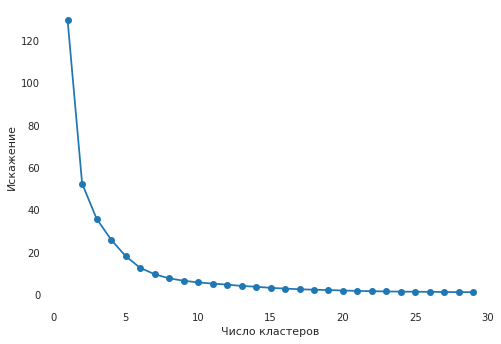

In [28]:
#Строим кластеры для ВСЕХ (тест+трейн) машин по предсказанным топикам - ищем общность в описании-предикте 
train_indx = pr_train.shape[0]
tmp_topics = pd.concat([pr_train, pr_test], axis=0)

draw_clusters_optimum_N(tmp_topics)

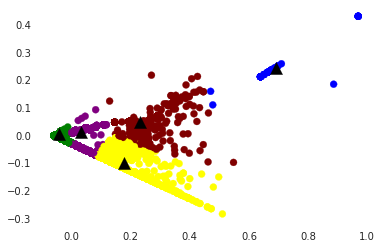

In [29]:
draw_clusters(tmp_topics, 5)

In [30]:
#Оптимальное к-во кластеров = 5
N_clust = 5
tmp_clust_tpoics = cluster_it(tmp_topics,N_clust)
pr_train_clust = tmp_clust_tpoics.iloc[0:train_indx].reset_index().drop(['index'], axis=1)
pr_test_clust = tmp_clust_tpoics.iloc[train_indx:].reset_index().drop(['index'], axis=1)

In [31]:
train = pd.concat([train, pr_train, pr_train_clust], axis=1)
test =  pd.concat([test,  pr_test, pr_test_clust ], axis=1) 

In [32]:
#Работаем с текстом из description - получаем эмбеддинги
text_featuers_model = TextFeatures(RANDOM_SEED, 3,\
                   ['!','.','•',')','(',':','[',']','*','-','_','пао','ooo','акб','https ://','http ://','https://','http://'])
if RUN_FROM_0:
    text_featuers_model.train(train['description'])
    text_featuers_model.model.save('DOC2VEC_model.model')
else:
     text_featuers_model.model = gensim.models.doc2vec.Doc2Vec.load('../input/langdata/DOC2VEC_model.model')#'DOC2VEC_model.model')

ftest = np.stack(test['description'].progress_apply(text_featuers_model.infer))
tmp_embedds = pd.concat([pd.DataFrame(text_featuers_model.model.docvecs.doctag_syn0), pd.DataFrame(ftest)], axis=0)

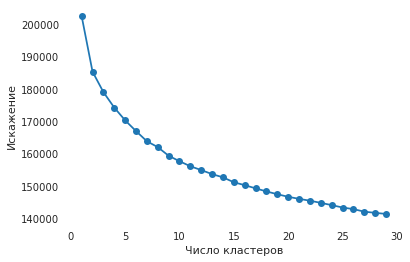

In [33]:
draw_clusters_optimum_N(tmp_embedds)

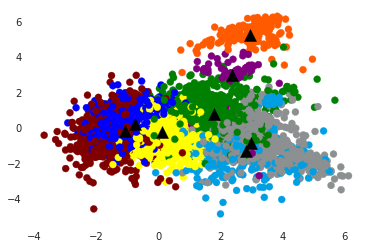

In [34]:
draw_clusters(tmp_embedds, 8)

In [35]:
# Кластеризуем эмбеддинги - пытаемся найти общность
pr_f_all = cluster_it(tmp_embedds, 10, "ft_")
pr_f = pr_f_all.iloc[0:train_indx].reset_index().drop(['index'], axis=1)
pr_f_t = pr_f_all.iloc[train_indx:].reset_index().drop(['index'], axis=1)

In [36]:
#Загружаем типичные текста диллеров и находим cosin сходство между СРЕДНИМ диллер-эмбеддингом и каждой машиной 
diller_txt=[]
diller_infers=[]
with open('/kaggle/input/dillers/dillers_txt.csv', encoding="utf8") as fp:
   for cnt, line in enumerate(fp):
       diller_txt.append(line)
       diller_infers.append(text_featuers_model.infer(line))
diller_infer_mean_infer = np.mean(diller_infers, axis=0)

dillers_col = tmp_embedds.apply(lambda row: np.abs(1 - spatial.distance.cosine(diller_infer_mean_infer, row.to_numpy(row))) ,axis=1)
dillers_col.name = 'dist_2_diller_txt'

dist_2_diller_txt_train = dillers_col.iloc[0:train_indx].reset_index().drop(['index'], axis=1)
dist_2_diller_txt_test = dillers_col.iloc[train_indx:].reset_index().drop(['index'], axis=1)

In [37]:
#Сливае датасеты с новыми фичами
train = pd.concat([train, dist_2_diller_txt_train, pr_f], axis=1)
test =  pd.concat([test, dist_2_diller_txt_test, pr_f_t], axis=1) 

--------------------

## Data Preprocessing

In [38]:
def fix_vehicleConfiguration(conf):
    '''
    Устраняем синонимы - может и излишне грубо
    '''
    return conf.strip().replace('Специальная серия', 'SE').\
    replace('(Локальная сборка)','').\
    replace('320d xDrive M Sport Pro', '320d xDrive M Sport').\
    replace('320d xDrive M Sport Pure', '320d xDrive M Sport').\
    replace('Базовая', 'X5 M').\
    strip()

In [39]:
def fix_vehicleConfiguration_row(row):
    '''
    Восстанавливаем vehicleConfiguration из name + modelDate
    '''
    ms=[]
    if row.vehicleConfiguration != '-NaN-': return  row.vehicleConfiguration
    #ms = train[(train['name'] == row['name']) & (train['modelDate'] == row['modelDate'])].vehicleConfiguration.mode()
    ms = train[(train['name'] == row['name'])].vehicleConfiguration.mode()
    if ms.size == 0:
        ms = train[(train['engineDisplacement'] == row['engineDisplacement']) 
                   & (train['bodyType'] == row['bodyType'])
                   & (train['enginePower'] == row['enginePower'])
                  ]['vehicleConfiguration'].mode()
        if ms.size == 0: return '-NaN-'
        
    return ms[0] 

In [40]:
def post_fix_vehicleFeatures_row(row, df):
    
    def fill_pack(packs):
        #print(packs.index,'\n', packs)
        res = ''
        if packs.size >0:
            if packs.index[0].replace('|','') != '-NaN-':
                res = packs.index[0]
            else:
                if packs.size >= 2:
                    res = packs.index[1]
        else:
            res = ''
        return res
    
    res = ''
    packs = df[  (df['name']==row['name']) & (df['modelDate']==row['modelDate'])  ]['Комплектация_1'].value_counts()
    res = fill_pack(packs)
    if res == '':
        packs = df[  (df['vehicleConfiguration']==row['vehicleConfiguration']) & (df['modelDate']==row['modelDate'])  ]['Комплектация_1'].value_counts()
        res = fill_pack(packs)
    
    return res
            

In [41]:
available_elements = []
available_packs = []

def get_vehicleFeatures_packs(row):
    '''
    Получение всех возможных пакетов опций
    '''
    packs = []
    if row['Комплектация'].strip() == '' or row['Комплектация'].strip() == '[]':
        return ['-NaN-']

    car_options_packs = json.loads(ast.literal_eval(row['Комплектация'])[0])
        
    for pack in car_options_packs:
        packs.append(pack['name'])
       
    return packs 

def get_vehicleFeatures_components(row):
    '''
    Получение всех возможных отдельных опций
    '''
    packs = []
    elements = []
    if row['Комплектация'].strip() == '' or row['Комплектация'].strip() == '[]':
        return ['-NaN-']

    car_options_packs = json.loads(ast.literal_eval(row['Комплектация'])[0])
        
    for pack in car_options_packs:
        packs.append(pack['name'])
        elements.extend(pack['values'])   
        
    return elements 

available_elements.extend(train.apply(get_vehicleFeatures_components, axis=1).values)
available_elements.extend(test.apply(get_vehicleFeatures_components, axis=1).values)
available_elements = [val for sublist in available_elements for val in sublist]

available_packs.extend(train.apply(get_vehicleFeatures_packs, axis=1).values)
available_packs.extend(test.apply(get_vehicleFeatures_packs, axis=1).values)
available_packs = [val for sublist in available_packs for val in sublist]

#main_features = pd.Series(available_elements).value_counts()[20:90].index
#main_features = pd.Series(available_elements).value_counts()[10:95].index
#main_features = pd.Series(available_elements).value_counts()[10:130].index
#main_features = pd.Series(available_elements).value_counts().index
cut=-1 * np.round(len(set(available_elements))*0.1, 0)
main_features = pd.Series(available_elements).value_counts().index[:int(cut)]

main_packs = pd.Series(available_packs).value_counts().index

# main_features - dummy колонки опций

In [42]:
def get_vehicleFeatures_components1(row):
    '''
    заполняем dummy колонки
    '''
    comps = get_vehicleFeatures_components(row)
    for comp in comps:
        if comp in main_features:
            row[comp] = 1
#         else:
#             row['other_f'] = 1
#             #print(comp)
    return row

def get_vehicleFeatures_packs1(row):
    '''
    заполняем dummy колонки
    '''
    comps = get_vehicleFeatures_packs(row)
    for comp in comps:
        if comp in main_packs:
            row[comp] = 1
#         else:
#             row['other_f'] = 1
#             #print(comp)
    return row

In [43]:
def fix_vehicleFeatures_row(row):
    '''

    '''
    packs = []
    try:
        if row['Комплектация'].strip() == '' or row['Комплектация'].strip() == '[]':
            return ['-NaN-']
        car_options_packs = json.loads(ast.literal_eval(row['Комплектация'])[0])
        for pack in car_options_packs:
            packs.append(pack['name'])
    except:
        print('--->', row['Комплектация'], '<---')
          
    return packs 

In [44]:

def rearrange_feature_packs(packs, feature_packs):
    '''
    Упорядочиваем позицию пакетов в списке - каждый пакет в каждой записи стоит на одном и том же месте  
    ['', 'Элементы экстерьера', '', '', '', '', 'Обзор', '', '', '']
    dummies не дают вообще никакого прироста
    '''
    #feature_packs = pd.unique(train_preproc['Комплектация_1'].apply(pd.Series).values.ravel('K'))
    car_feature_packs_dict = dict((pack,0) for pack in feature_packs) #feature_packs-все возможные пакеты

    for pack in packs:
        car_feature_packs_dict[pack]=1

    ret = ['' if car_feature_packs_dict[pack] == 0 else pack for pack in car_feature_packs_dict]#feature_packs_dict]

    str1 = '|'.join(str(e) for e in ret)

    return str1# ret # #

#row = [train_preproc['Комплектация_1'][4]][0]
#rearrange_feature_packs(row, train_preproc)

In [45]:
train['vehicleConfiguration'] = train['vehicleConfiguration'].apply(fix_vehicleConfiguration)
train['vehicleConfiguration'] = train.apply( fix_vehicleConfiguration_row, axis=1)
    
test['vehicleConfiguration'] = test['vehicleConfiguration'].apply(fix_vehicleConfiguration)
test['vehicleConfiguration'] = test.apply( fix_vehicleConfiguration_row, axis=1)

In [46]:
def preproc_data_9(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    def calc_eng_power_2_user(row):
        n=3
        if row['Владельцы']=='3 или более': n=3
        if row['Владельцы']=='1 владелец': n=1
        if row['Владельцы']=='2 владельца': n=2
            
        return round(row['enginePower']/n,0)
     
    def fix_owners(val):
        n=3
        if val =='3 или более': n=3
        if val =='1 владелец': n=1
        if val =='2 владельца': n=2

        return 'owners_' + str(n)           
            
    df_output = df_input.copy()


    # ################### Предобработка ############################################################## 
    # убираем не нужные для модели признаки

    df_output.drop(['Таможня', 'Состояние', 'id', 'brand'], axis=1, inplace=True,)
    
    # ################### fix ############################################################## 
    # Переводим признаки из float в int (иначе catboost выдает ошибку)
    for feature in ['numberOfDoors', 'mileage', 'productionDate', 'modelDate']:
        df_output[feature]=df_output[feature].astype('int32')
    
    
    # ################### Feature Engineering ####################################################
    
    # основные цвета автомобилей BMW
    body_colors = ['чёрный', 'белый', 'серый', 'синий', 'серебристый'] 
    df_output['color'] = df_output['color'].apply(lambda c: c if c in body_colors else 'other')
    
    #основные кузова BMW - только ухудшает результат
    body_types = ['седан', 'внедорожник 5 дв.,' 'купе', 'хэтчбек 5 дв.', 'хэтчбек 3 дв.', 'универсал 5 дв.', 'кабриолет']
    df_output['bodyType'] = df_output['bodyType'].apply(lambda c: c if c in body_types else 'other')
    
    # enginePower в число
    kvt_filter = df_output.enginePower.str.contains('\xa0кВт') #1.35962
    df_output['enginePower'] = df_output['enginePower'].str.replace(' N12','')
    df_output['enginePower'] = df_output['enginePower'].str.replace('\xa0кВт','')
    df_output['enginePower'] = df_output['enginePower'].astype('int32')
    df_output[kvt_filter]['enginePower'] = round(df_output[kvt_filter]['enginePower'] * 1.35962,0)# электрокары привели к ДВС

    
    #df_output['mileage'] = round(df_output['mileage'] / ROUND_C,0) * ROUND_C
    df_output['mileage'] = round(df_output['mileage'],0)
    df_output['mileage'] = df_output['mileage'].astype('int32')
    df_output.loc[df_output['mileage'] > 300000,'mileage'] = 300000 # после 300000км уже всё равно
    

    
    df_output['km_per_year'] = df_output['mileage'] /  (CURR_YEAR+1 - df_output['productionDate'])
    #Потеря мощности от пробега
    df_output['km_per_year_power'] = df_output['enginePower'] * (1- df_output['mileage']/300000) #( *  (CURR_YEAR - df_output['productionDate']))
    
    df_output.loc[df_output['fuelType'] == 'электро','engineDisplacement'] = '0 LTR' # электрокары привели к ДВС
    df_output['engineDisplacement'] = df_output['engineDisplacement'].str.replace(' LTR','').astype('float')
    
    #к-во символов в описании
    df_output['description_l'] = df_output['description'].str.len()
    #к-во слов в описании
    df_output['description_l1'] = df_output['description'].apply(lambda x: len(str(x).split()))
    #комплектация в упрощенном виде
    df_output['Комплектация_1'] = df_output.apply(fix_vehicleFeatures_row, axis=1)   

   
    df_output['enginePower2user'] = df_output.apply(calc_eng_power_2_user, axis=1)
    df_output['enginePower2user'] = df_output['enginePower2user'].astype('int32')
    
    df_output['enginePower2liter'] = df_output['enginePower'] / (df_output['engineDisplacement'] + 0.1)
    
    #упрощенное имя
    df_output['name_1'] = df_output['name'].apply(lambda x: str(x).split()[0])
    
    #завязываем все даты на текущий год
    df_output['modelDate'] = CURR_YEAR - df_output['modelDate']
    df_output['productionDate'] = CURR_YEAR - df_output['productionDate']
    
    df_output['isDillesrSell'] =  df_output['dist_2_diller_txt'].apply(lambda x: 1 if x >= DILLER_THRESHOLD else 0) 
    
    df_output['Владельцы'] = df_output['Владельцы'].apply(fix_owners)
    
    #tqdm.pandas()
    #Заполняем 0/1 фичи-конфигурации АМ (в смысле всякие климаты/диски/кожа)
    for f in main_features:
        df_output[f] = 0
    df_output= df_output.progress_apply(lambda row: get_vehicleFeatures_components1(row), axis=1)
    df_output[main_features] = df_output[main_features].fillna(0, inplace=False)
    
#     for f in main_packs:
#         df_output[f] = 0
#     df_output= df_output.progress_apply(lambda row: get_vehicleFeatures_packs1(row), axis=1)
#     df_output[main_packs] = df_output[main_packs].fillna(0, inplace=False)
    

    # ################### Clean #################################################### 
    # убираем признаки которые не нужны уже 
    df_output.drop(['Комплектация', 'description', 'Владение', 'Руль'], axis=1, inplace=True,)
    
    return df_output

In [47]:
train_preproc = preproc_data_9(train)
X_sub = preproc_data_9(test)

In [48]:
#feature_packs-все возможные пакеты!!!!

# Доводим Комплектация_1 до состояния пригодного к прямому сравнению
feature_packs = pd.unique(train_preproc['Комплектация_1'].apply(pd.Series).values.ravel('K'))

train_preproc['Комплектация_1'] = train_preproc['Комплектация_1'].apply(lambda row: rearrange_feature_packs(row, feature_packs))
X_sub['Комплектация_1'] = X_sub['Комплектация_1'].apply(lambda row: rearrange_feature_packs(row, feature_packs))

train_preproc['Комплектация_1'] = train_preproc.apply(lambda row: post_fix_vehicleFeatures_row(row, train_preproc), axis=1)
X_sub['Комплектация_1'] = X_sub.apply(lambda row: post_fix_vehicleFeatures_row(row, train_preproc), axis=1)

top10_packs = train_preproc['Комплектация_1'].value_counts()[0:10].index.to_list()

train_preproc['Комплектация_1'] = train_preproc['Комплектация_1'].apply(lambda c: c if c in top10_packs else 'other')
X_sub['Комплектация_1'] = X_sub['Комплектация_1'].apply(lambda c: c if c in top10_packs else 'other')


In [49]:
train_preproc.drop(['url'], axis=1, inplace=True,) # убрал лишний столбец, которого нет в testе
#Округлили цену с заданной кратностью и внесли поправку на разницу в ценах 7мес назад и сейчас
train_preproc['price'] = round(train_preproc['price'] * PRICE_IN_TIME / ROUND_C,0) * ROUND_C
train_preproc['price'] = train_preproc['price'].astype('int32')

In [50]:
#design_report_proc = ProfileReport(train_preproc);


In [51]:
#design_report_proc.to_notebook_iframe();

In [52]:
X = train_preproc.drop(['price'], axis=1,)
y = train_preproc.price.values

## Train Split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Сat features
CatBoost умеет самостоятельно обрабатывать категориальные признаки, но для корректной обработки нужно их указать:

In [54]:

cat_features = ['bodyType', 'color', 'fuelType',# 'name',
       'vehicleConfiguration', 'vehicleTransmission',
        'Привод','Владельцы', 'ПТС','Grp_ID',# 'Руль', #'engineDisplacement',
        'Комплектация_1', 'ft_', 'name_1', 'name', 'isDillesrSell' ]
cat_features.extend(main_features)


## Fit

In [55]:
#Посмотрим как ведет себя модель и подготовим признаки на исключение
model = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = 0.1,#LR,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          od_type = 'IncToDec',
                          od_pval = OD_PVAL,
                          l2_leaf_reg =L2_REG,
                         )

model.fit(X_train, y_train,
         cat_features=cat_features, #cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True,
 
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.1914285	test: 1.1522009	best: 1.1522009 (0)	total: 94ms	remaining: 7m 49s
100:	learn: 0.1657830	test: 0.1668291	best: 0.1668291 (100)	total: 2.23s	remaining: 1m 48s
200:	learn: 0.1453371	test: 0.1512793	best: 0.1512648 (199)	total: 4.38s	remaining: 1m 44s
300:	learn: 0.1331219	test: 0.1422369	best: 0.1422290 (299)	total: 6.65s	remaining: 1m 43s
400:	learn: 0.1267884	test: 0.1392675	best: 0.1392675 (400)	total: 8.99s	remaining: 1m 43s
500:	learn: 0.1217556	test: 0.1365769	best: 0.1364992 (492)	total: 11.3s	remaining: 1m 41s
600:	learn: 0.1176001	test: 0.1348810	best: 0.1347663 (595)	total: 13.6s	remaining: 1m 39s
700:	learn: 0.1133600	test: 0.1327735	best: 0.1327735 (700)	total: 16s	remaining: 1m 37s
800:	learn: 0.1095264	test: 0.1318794	best: 0.1318293 (789)	total: 18.8s	remaining: 1m 38s
900:	learn: 0.1066055	test: 0.1315494	best: 0.1312431 (875)	total: 21.3s	remaining: 1m 37s
1000:	learn: 0.1036837	test: 0.1307858	best: 0.1307547 (999)	total: 23.9s	remaining: 1m 35s
1100:

In [56]:
print(model.get_all_params())

{'nan_mode': 'Min', 'eval_metric': 'MAPE', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'], 'iterations': 5000, 'sampling_frequency': 'PerTree', 'fold_permutation_block': 0, 'leaf_estimation_method': 'Newton', 'od_pval': 0.0020000000949949026, 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'ctr_leaf_count_limit': 18446744073709551615, 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'l2_leaf_reg': 4.5, 'random_strength': 1, 'od_type': 'IncToDec', 'rsm': 1, 'boost_from_average': True, 'max_ctr_complexity': 4, 'model_size_reg': 0.5, 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:

In [57]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(15,40))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [58]:
#подготовим признаки на исключение
f_imp = 0.04 # min значимость признака
prediction_diff = model.get_feature_importance(type= "PredictionValuesChange", prettified=True)
features_for_remove = prediction_diff[prediction_diff.Importances <= f_imp]['Feature Id']

X_sub.drop(features_for_remove, axis=1, inplace=True,)
X.drop(features_for_remove, axis=1, inplace=True,)

cat_features = [x for x in cat_features if x  in X.columns]

prediction_diff[prediction_diff.Importances > f_imp]

,Feature Id,Importances
0,productionDate,23.038560
1,modelDate,21.853621
2,km_per_year_power,12.823617
3,enginePower2user,6.761823
4,mileage,5.536091
...,...,...
60,Климат-контроль многозонный,0.044836
61,Система предотвращения столкновения,0.044451
62,Мультимедиа система с ЖК-экраном,0.043217
63,Вентиляция передних сидений,0.042683


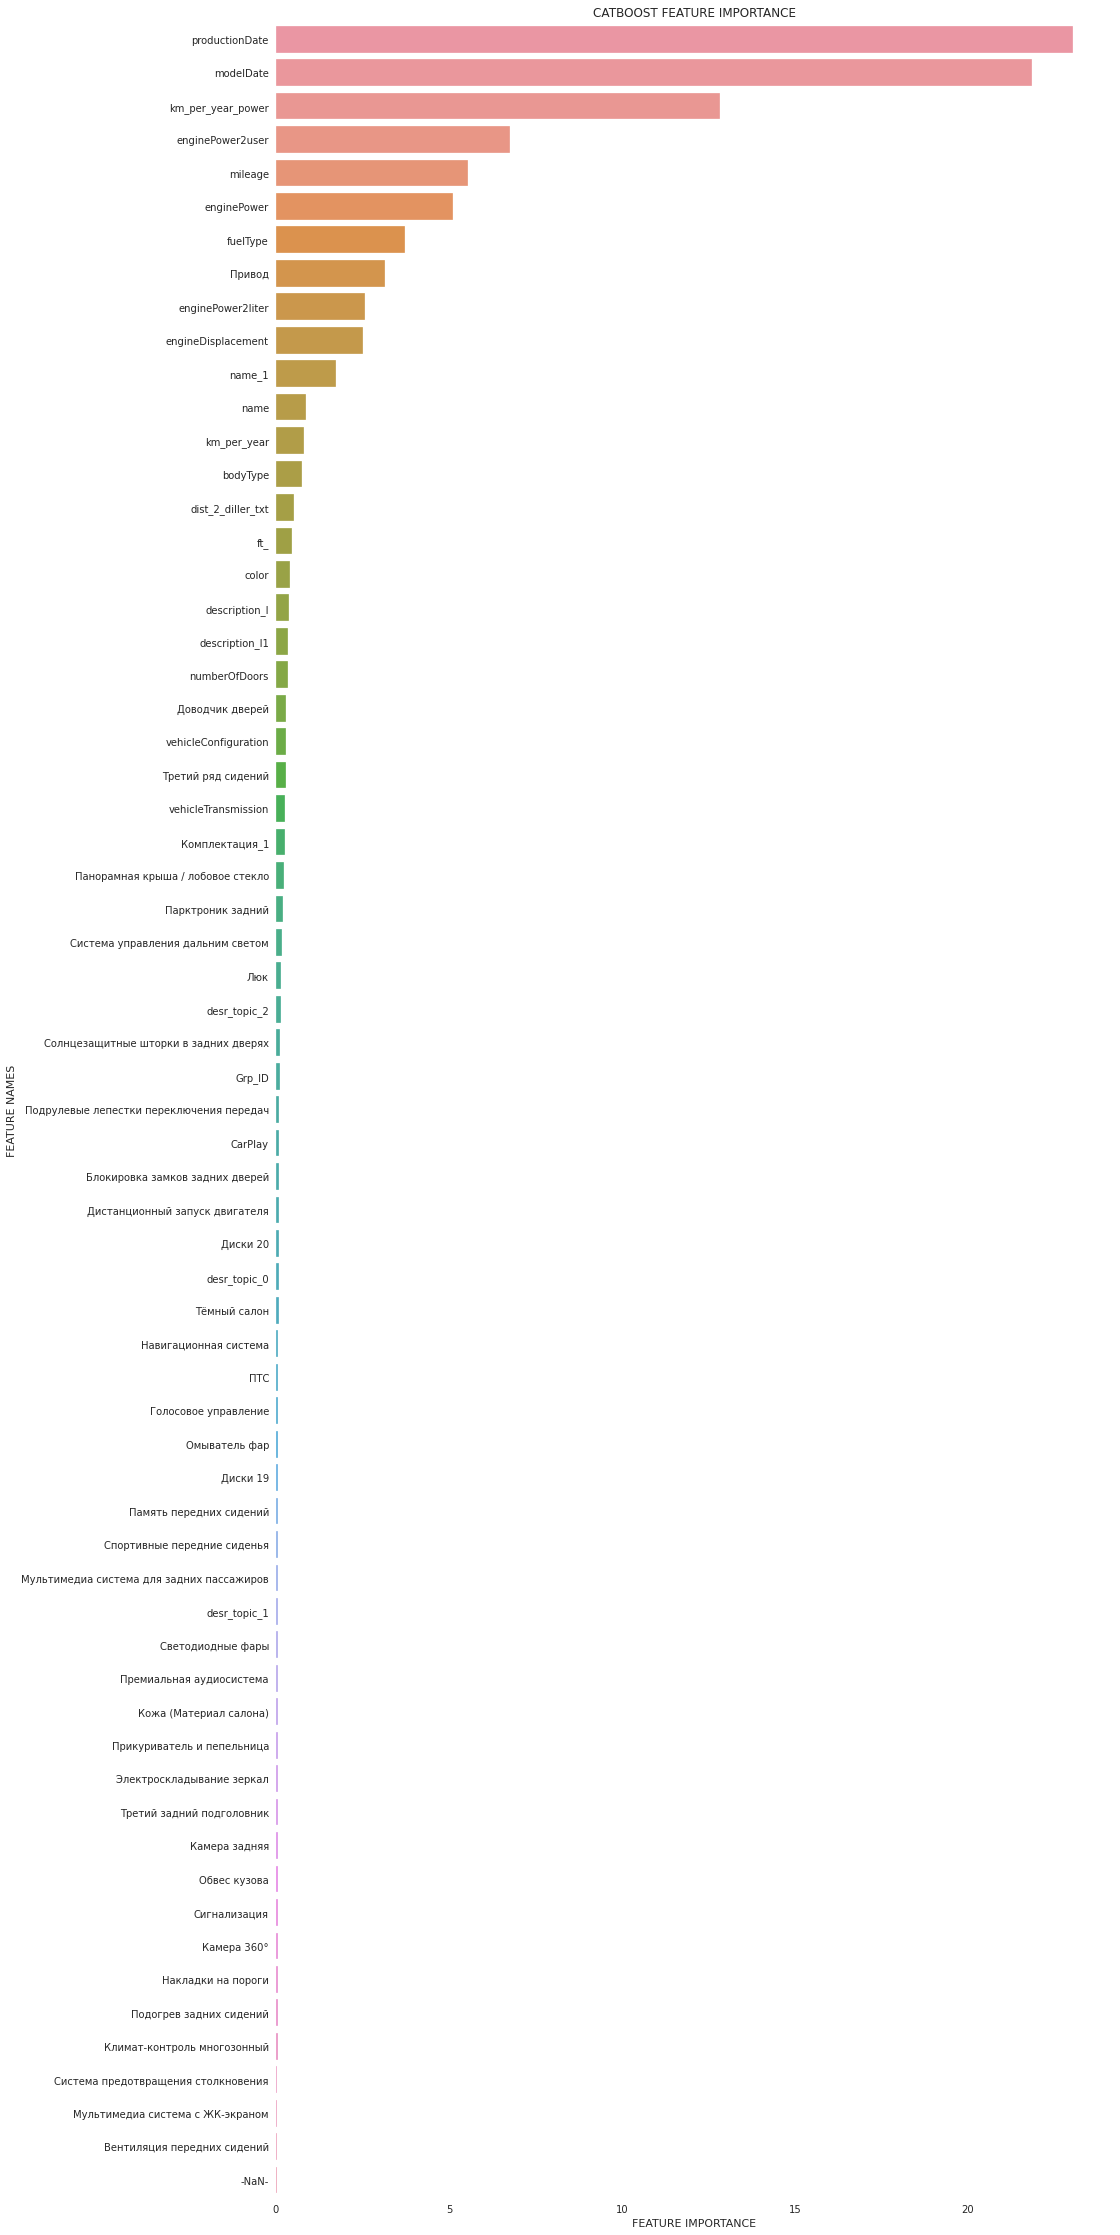

In [59]:
plot_feature_importance(prediction_diff[prediction_diff.Importances > f_imp]['Importances'],\
                        prediction_diff[prediction_diff.Importances > f_imp]['Feature Id'],'CATBOOST ')

In [60]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations = ITERATIONS,
                              learning_rate = LR,
                              eval_metric='MAPE',
                              random_seed = RANDOM_SEED,
                              od_type = 'IncToDec',
                              od_pval = OD_PVAL,
                              l2_leaf_reg = L2_REG,
                              #one_hot_max_size=6,
                              #random_strength=0,
                              #l2_leaf_reg = L2_REG
                              #od_type='Iter',
                              #od_wait=20
                              #l2_leaf_reg = 4
                             )
  
    model.fit(X_train, y_train,
              cat_features=cat_features,#_idx, #cat_features_ids
              eval_set=(X_test, y_test),
              verbose=False,
              use_best_model=True,
              plot=False)
    
    return(model)


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [61]:
# кросс-валидацию по фолдам для борьбы с переобучением
#'''
from sklearn.model_selection import RepeatedKFold

submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) # куда пишем предикты по каждой модели
score_ls = []
N_FOLDS = 10
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED).split(X, y))
#splits = list(RepeatedKFold(n_splits=N_FOLDS, n_repeats=2, random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    # use the indexes to extract the folds in the train and validation data
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    # model for this fold
    model = cat_model(y_train, X_train, X_test, y_test,)
    # score model on test
    test_predict = model.predict(X_test)
    test_score = mape(y_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict):0.3f}")
    # submissions
    submissions[f'sub_{idx+1}'] = model.predict(X_sub)
    model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')
#'''

1 Fold Test MAPE: 0.129
2 Fold Test MAPE: 0.130
3 Fold Test MAPE: 0.127
4 Fold Test MAPE: 0.140
5 Fold Test MAPE: 0.145
6 Fold Test MAPE: 0.134
7 Fold Test MAPE: 0.136
8 Fold Test MAPE: 0.135
9 Fold Test MAPE: 0.139
10 Fold Test MAPE: 0.132

Mean Score: 0.135
Std Score: 0.0054
Max Score: 0.145
Min Score: 0.127


### Submissions blend

In [62]:
submissions['blend'] = (submissions.sum(axis=1))/len(submissions.columns)
sample_submission['price'] = submissions['blend'].values
sample_submission['price'] = round(sample_submission['price'] / ROUND_C,0) * ROUND_C
sample_submission['price'] = sample_submission['price'].astype('int32')
sample_submission['price'] = sample_submission['price'].astype('float')
sample_submission.to_csv(f'submission_blend_v{VERSION}.csv', index=False)
sample_submission.head(10)

,id,price
0,0,1530000.0
1,1,2335000.0
2,2,1215000.0
3,3,2390000.0
4,4,4935000.0
5,5,2030000.0
6,6,1055000.0
7,7,635000.0
8,8,1360000.0
9,9,1380000.0


## Stacking   
### сохраним данные для последующего Stacking-а  
### Stacking реализуется в нотбуке sf-dst-10-car-price-prediction-kuzmenko_stacking.ipynb (Stacking не дал улучшения MAPE) :)



In [63]:
X.to_csv('X_all.csv')
pd.Series(y).to_csv('y_all.csv')
X_sub.to_csv('X_sub_all.csv')

with open('cat_features.npy', 'wb') as f:
    np.save(f, np.array(cat_features))